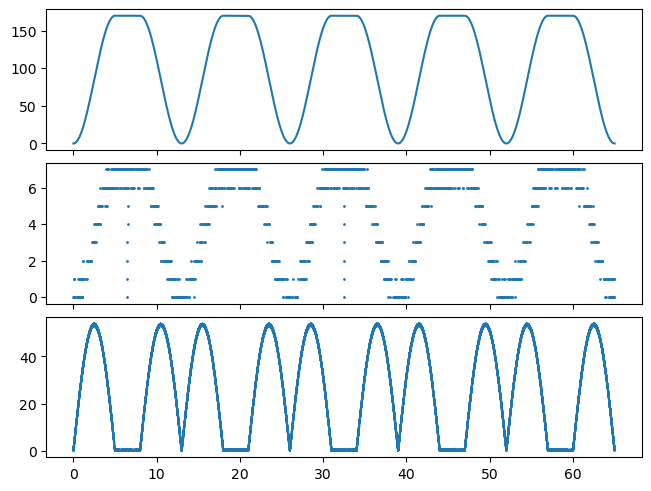

In [1]:
from src.simulate import make_simulated_data
import matplotlib.pyplot as plt
import numpy as np

speed, position, spikes, time, ripple_times, sampling_frequency = make_simulated_data()

fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True)
axes[0].plot(time, position)
spike_time_ind, neuron_ind = np.nonzero(spikes)
axes[1].scatter(time[spike_time_ind], neuron_ind, s=1)
axes[2].plot(time, speed)


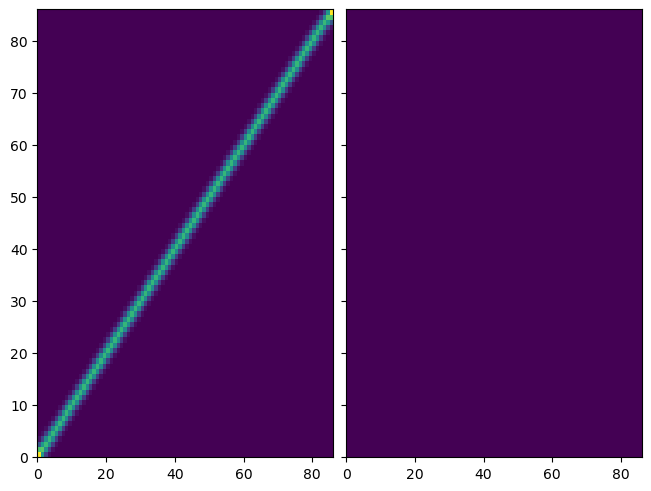

In [17]:
from replay_trajectory_classification import RandomWalk, Environment, Uniform

env = Environment().fit_place_grid(position[:, None])
random_walk = RandomWalk().make_state_transition([env])
uniform = Uniform().make_state_transition([env])

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout=True)
axes[0].pcolormesh(random_walk.T)
axes[1].pcolormesh(uniform.T)

In [193]:
# local, no spike, continuous, fragmented

n_states = 4
n_env_bins = env.place_bin_centers_.shape[0]
bin_sizes = [1, 1, n_env_bins, n_env_bins]

state_ind = np.concatenate([ind * np.ones((bin_size,), dtype=int) for ind, bin_size in enumerate(bin_sizes)])
n_state_bins = len(state_ind)

initial_conditions = np.zeros((n_state_bins,))
initial_conditions[state_ind == 0] = 1.0

continuous_state_transitions = np.zeros((n_state_bins, n_state_bins))
discrete_state_transitions = np.asarray([[0.99,   0.01/3, 0.01/3, 0.01/3],
                                         [0.01/3, 0.99,   0.01/3, 0.01/3],
                                         [0.02/3, 0.02/3, 0.98,   0.02/3],
                                         [0.02/3, 0.02/3, 0.02/3, 0.98],
                                         ])
discrete_state_transitions_per_bin = discrete_state_transitions[state_ind[:, np.newaxis], state_ind]

continuous_state_transitions = np.zeros((n_state_bins, n_state_bins))
from_state_ind, to_state_ind = np.meshgrid(state_ind, state_ind)
from_state_ind, to_state_ind = from_state_ind.T, to_state_ind.T

for from_state in range(n_states):
    for to_state in range(n_states):
        
        inds = (from_state_ind == from_state) & (to_state_ind == to_state)
        
        if (bin_sizes[from_state] == 1) & (bin_sizes[to_state] == 1):
            # transition from discrete to discrete
            continuous_state_transitions[inds] = 1.0
        elif (bin_sizes[from_state] > 1) & (bin_sizes[to_state] == 1):
            # transition from continuous to discrete
            continuous_state_transitions[inds] = 1.0
        elif (bin_sizes[from_state] == 1) & (bin_sizes[to_state] > 1):
            # transition from discrete to continuous
            continuous_state_transitions[inds] = 1.0 / bin_sizes[to_state] # uniform
        else:
            # transition from continuous to continuous
            if from_state != to_state:
                continuous_state_transitions[inds] = 1.0 / bin_sizes[to_state] # uniform
            else:
                transition_matrix = random_walk.copy()
                continuous_state_transitions[np.nonzero(inds)] = transition_matrix.ravel()
                

In [195]:
(continuous_state_transitions * discrete_state_transitions_per_bin).sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

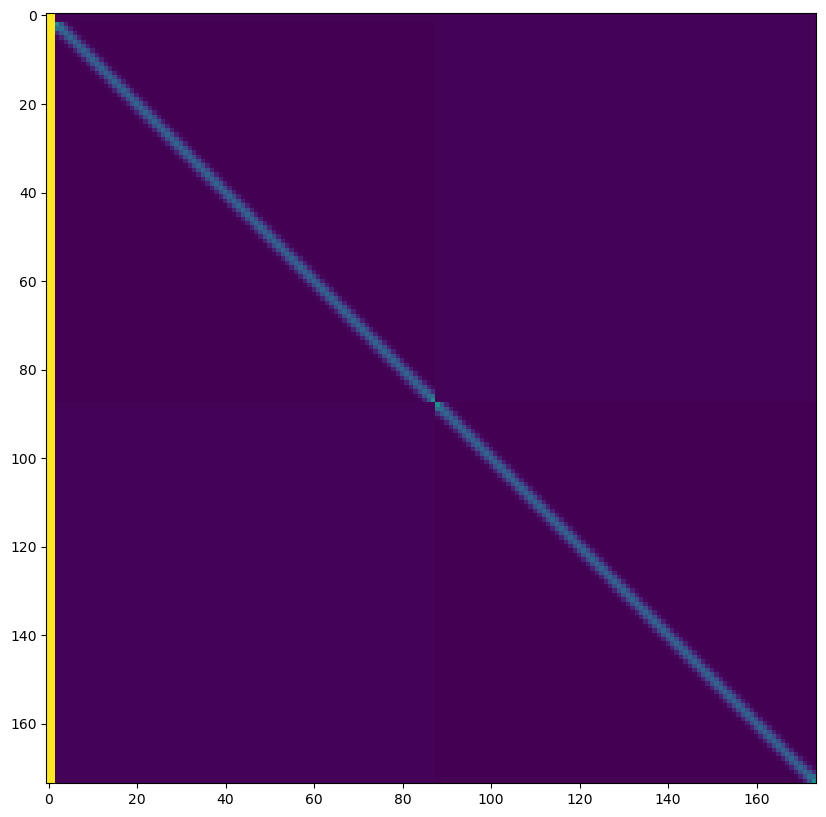

In [176]:
plt.figure(figsize=(10, 10))
plt.imshow(continuous_state_transitions)

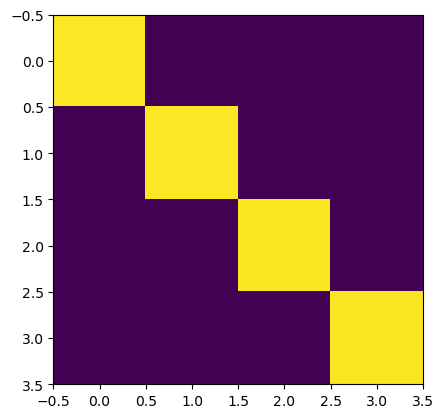

In [54]:
plt.imshow(discrete_state_transitions)

In [75]:
from patsy import DesignInfo, DesignMatrix, build_design_matrices, dmatrix
import numpy as np
from scipy.optimize import minimize

import jax
import jax.numpy as jnp

from sklearn import linear_model

def fit_regression(design_matrix, weights, spikes, position):

    @jax.jit
    def neglogp(
        coefficients, spikes=spikes, design_matrix=design_matrix, weights=weights
    ):
        conditional_intensity = jnp.exp(design_matrix @ coefficients)
        log_likelihood = weights * jax.scipy.stats.poisson.logpmf(
            spikes.astype(float), conditional_intensity + np.spacing(1)
        )
        return -log_likelihood.sum()

    dlike = jax.grad(neglogp)
    dlike2 = jax.hessian(neglogp)
    
    initial_condition = np.array([np.log(np.average(spikes, weights=weights))])
    initial_condition = np.concatenate([initial_condition, np.zeros(design_matrix.shape[1] - 1)])

    res = minimize(
        neglogp, x0=initial_condition, method="Newton-CG", jac=dlike, hess=dlike2
    )

    return res.x

def make_spline_predict_matrix(
    design_info: DesignInfo, place_bin_centers: np.ndarray
) -> DesignMatrix:
    """Make a design matrix for position bins"""
    predict_data = {}
    predict_data[f"x"] = place_bin_centers
        
    return build_design_matrices([design_info], predict_data)[0]

In [254]:
from src.hmm import (
    forward,
    correction_smoothing,
    update_transition_matrix_from_correction_smoothing,
    viterbi,
    check_converged,
    poisson_log_likelihood
)

n_time = spikes.shape[0]
is_training = np.ones((n_time,))

df = 4
data = {"x": position}
design_matrix = dmatrix(f"bs(x, df={df})", data)
zero_rates = np.ones_like(spikes) * 1e-5 / sampling_frequency

coefficients = np.stack([fit_regression(design_matrix, is_training.astype(float), s, position) for s in spikes.T], axis=1)

rates = np.exp(design_matrix @ coefficients)

likelihood = np.zeros((n_time, n_state_bins))
likelihood[:, state_ind==0] = np.exp(np.sum(poisson_log_likelihood(spikes, rates), axis=-1))[:, np.newaxis]
likelihood[:, state_ind==1] = np.exp(np.sum(poisson_log_likelihood(spikes, zero_rates), axis=1))[:, np.newaxis]

predict_matrix = make_spline_predict_matrix(design_matrix.design_info, env.place_bin_centers_)
rates = np.exp(predict_matrix @ coefficients)
likelihood_over_bins = np.exp(np.sum(poisson_log_likelihood(spikes[:, np.newaxis], rates[np.newaxis]), axis=-1))

likelihood[:, state_ind==2] = likelihood_over_bins
likelihood[:, state_ind==3] = likelihood_over_bins

In [263]:
transition_matrix = discrete_state_transitions_per_bin * continuous_state_transitions
# Expectation step
causal_posterior, data_log_likelihood, scaling = forward(
    initial_conditions, likelihood, transition_matrix
)

acausal_posterior = correction_smoothing(causal_posterior, transition_matrix)

In [ ]:
state_probabilities = np.zeros((n_time, n_states))

for ind in range(n_states):
    state_probabilities[:, ind] = acausal_posterior[:, state_ind==ind].sum(axis=1)

In [ ]:
position_decode = acausal_posterior[:, np.isin(state_ind, [2, 3])].reshape((-1, 2, n_env_bins)).sum(axis=1)
t, x = np.meshgrid(time, env.place_bin_centers_)

(0.0, 50.0)

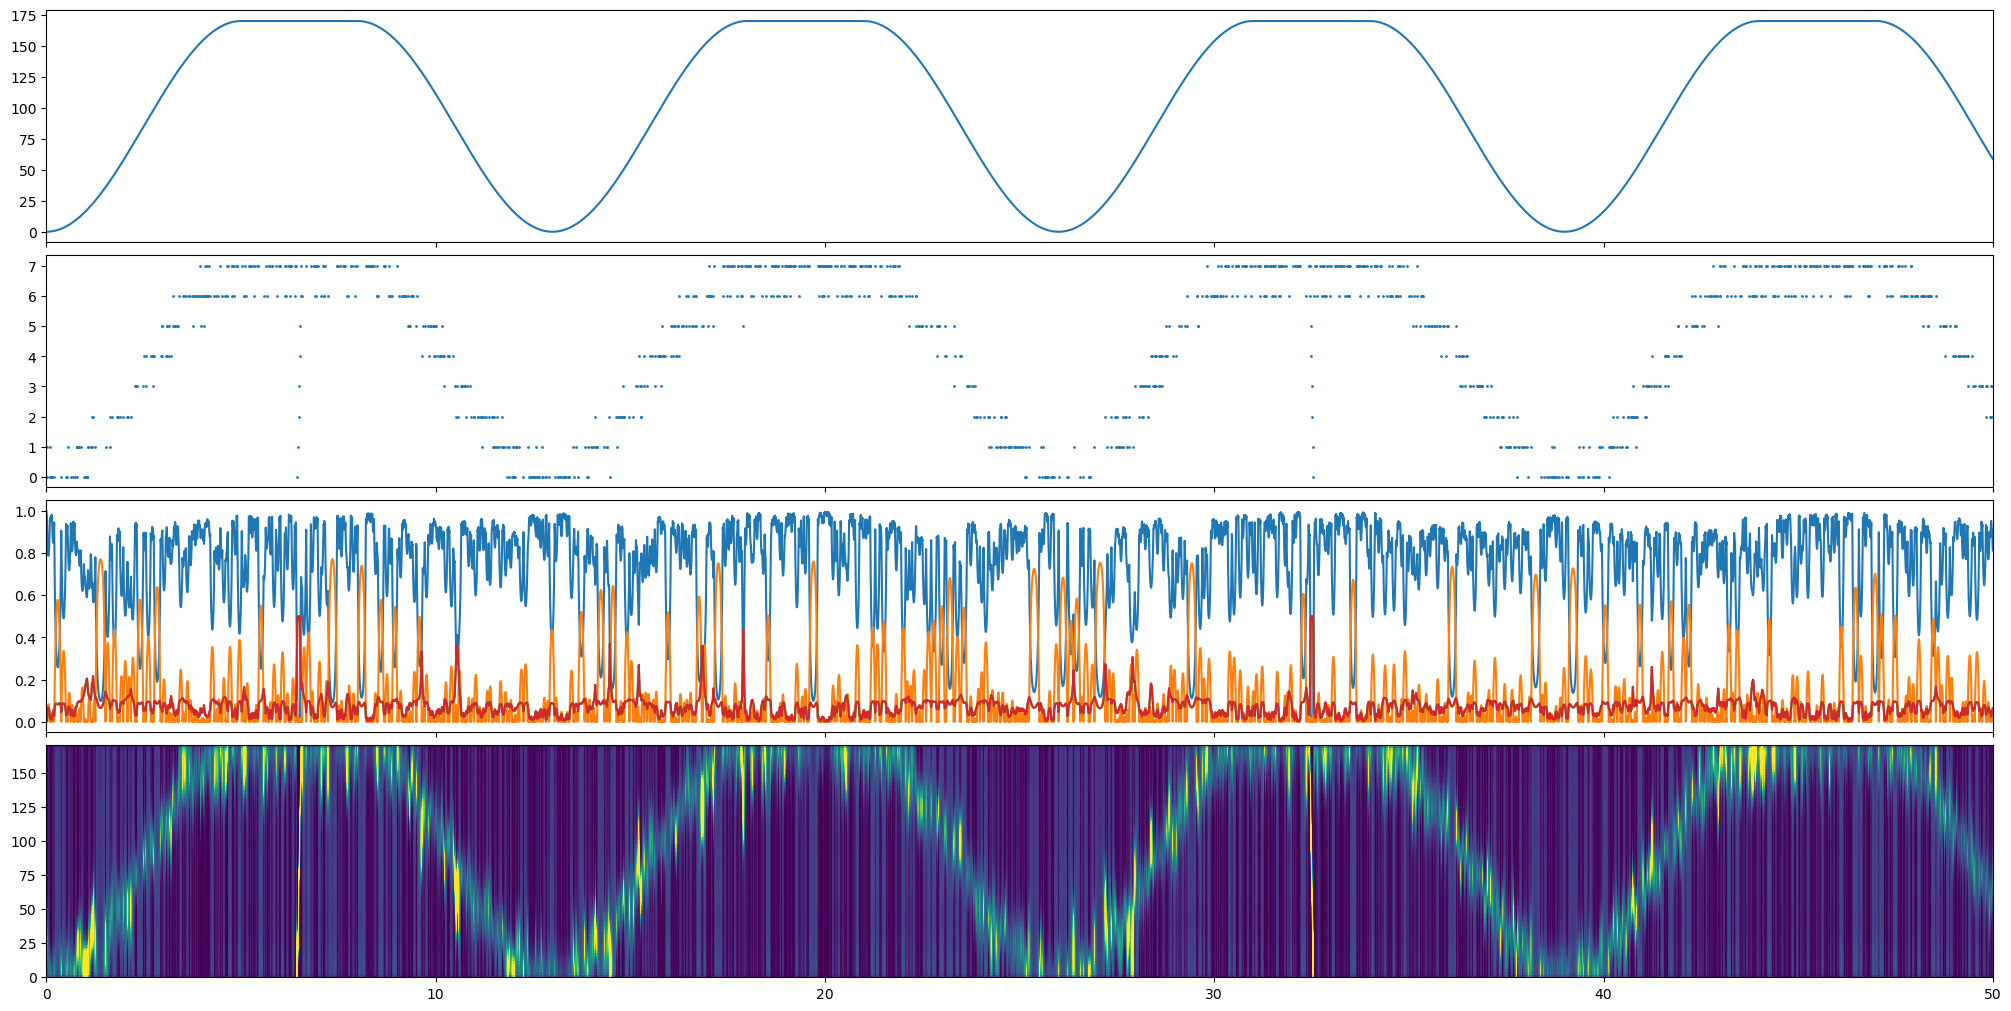

In [ ]:
fig, axes = plt.subplots(4, 1, sharex=True, constrained_layout=True, figsize=(20, 10))
axes[0].plot(time, position)
spike_time_ind, neuron_ind = np.nonzero(spikes)
axes[1].scatter(time[spike_time_ind], neuron_ind, s=1)
axes[2].plot(time, state_probabilities)
axes[3].pcolormesh(t, x, position_decode.T, vmin=0.0, vmax=0.01)
plt.xlim((0, 50))

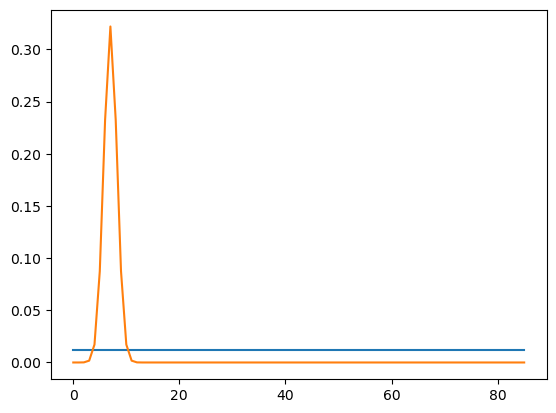

In [161]:
ind = 95
plt.plot(continuous_state_transitions[ind, 2:88])
plt.plot(continuous_state_transitions[ind, -86:])